# Using `ncbi.datasets` library to download and parse virus datasets

The objective of this notebook is to use the `ncbi.datasets` python library to download and extract viral genome and annotation data.

First, let's import the python modules we'll use.  Be sure you have first installed the requirements in 'requirements.txt' into your virtual environment. 

In [1]:
import ncbi.datasets
import json
import os
import csv
import yaml
import zipfile
import pandas as pd
from pyfaidx import Fasta
from google.protobuf.json_format import ParseDict
import ncbi.datasets.v1alpha1.reports.virus_pb2 as virus_report_pb2
from collections import OrderedDict, Counter
from datetime import datetime, timezone, timedelta

We will need an api object specific to retrieving viral data. To see all the possible API instances, [visit the documentation on GitHub](https://github.com/ncbi/datasets/tree/master/client_docs/python#documentation-for-api-endpoints)". 

In [1]:
virus_api = ncbi.datasets.VirusApi(ncbi.datasets.ApiClient())

## The NCBI data report

Viral genome data downloaded using the NCBI Datasets API uses the same file hierarchy as the other assembly download objects (see [Assembly Jupyter Notebook](ncbi-datasets-assembly.ipynb) to learn more). The structured zip archive in the bdbag format contains a data report that can be traversed using the `ncbi.datasets` python library to extract metadata. 

To illustrate how one can use these files, we will download all RefSeq genomes for the coronaviridae family and extract some genome and annotation information in tabular form. 

In [1]:
## download all refseq genomes for the coronaviridate family (taxid 11118)

taxid = 11118

viral_genomes = virus_api.virus_genome_download(
    taxid, 
    refseq_only=True, 
    include_sequence=True,
    _preload_content=False
)

zipfn = 'ncbi_genomes.zip'
with open(zipfn, 'wb') as f:
    f.write(viral_genomes.data)

print(f'Download complete')

!unzip -v {zipfn}

Download complete
Archive:  ncbi_genomes.zip
 Length   Method    Size  Cmpr    Date    Time   CRC-32   Name
--------  ------  ------- ---- ---------- ----- --------  ----
     661  Defl:N      384  42% 09-08-2020 06:58 bc3c97af  README.md
 2614793  Defl:N   899491  66% 09-08-2020 06:58 ef541e86  ncbi_dataset/data/cds.fna
 1918794  Defl:N   666014  65% 09-08-2020 06:58 221be551  ncbi_dataset/data/genomic.fna
  952864  Defl:N   422108  56% 09-08-2020 06:58 594c4b3f  ncbi_dataset/data/protein.faa
 3925485  Defl:N  1554217  60% 09-08-2020 06:58 2d9bbdd4  ncbi_dataset/data/genomic.gbff
 3160554  Defl:N   749099  76% 09-08-2020 06:58 c94d7cdb  ncbi_dataset/data/protein.gpff
  774772  Defl:N   134620  83% 09-08-2020 06:58 01de2508  ncbi_dataset/data/data_report.yaml
    2398  Defl:N     1050  56% 09-08-2020 06:58 8d3e9da3  ncbi_dataset/data/virus_dataset.md
     624  Defl:N      221  65% 09-08-2020 06:58 97c30b30  ncbi_dataset/data/dataset_catalog.json
       0  Defl:N        2   0% 09-08-202

The contents of the bdbag archive are shown above. We will use the following function to extract data from the `data_report.yaml` file and read it into an object (named `virus_report` in this example).

As shown below, one can easily navigate through the contents of the `virus_report` object to extract data. 

In [1]:
# A utility class for working with virus dataset zipfiles.
from ncbi.datasets.package.dataset import VirusDataset

vd = VirusDataset(zipfn)

genome_data = []
for g in vd.get_report_assemblies():
    genome_data.append({
        'Accession': g.accession,
        'TaxID': g.virus.tax_id,
        'VirusName': g.virus.sci_name,
        'Host': g.host.sci_name,
        'Isolate': g.isolate.name,
        'Location': g.location.geographic_location,
        'Length': g.length,
        'Genes': g.gene_count,
        'Proteins': g.protein_count,
        'MaturePeptides': g.mature_peptide_count
    })
    
df1 = pd.DataFrame(genome_data)
df1.head()

,Accession,TaxID,VirusName,Host,Isolate,Location,Length,Genes,Proteins,MaturePeptides
0,NC_001451.1,11120,Infectious bronchitis virus,,,,27608,6,10,14
1,NC_001846.1,11138,Murine hepatitis virus,,,,31357,5,7,26
2,NC_002306.3,11135,Feline infectious peritonitis virus,,79-1146,USA,29355,10,9,0
3,NC_002645.1,11137,Human coronavirus 229E,,,,27317,7,8,0
4,NC_003436.1,28295,Porcine epidemic diarrhea virus,,,,28033,6,6,13


We can now quickly generate plots using the data in the dataframe. For example, a set of histograms showing the distribution of the length of the genomes, and the number of genes, proteins and mature peptides is shown below. 

array([[<AxesSubplot:title={'center':'Length'}>,
        <AxesSubplot:title={'center':'Genes'}>],
       [<AxesSubplot:title={'center':'Proteins'}>,
        <AxesSubplot:title={'center':'MaturePeptides'}>]], dtype=object)

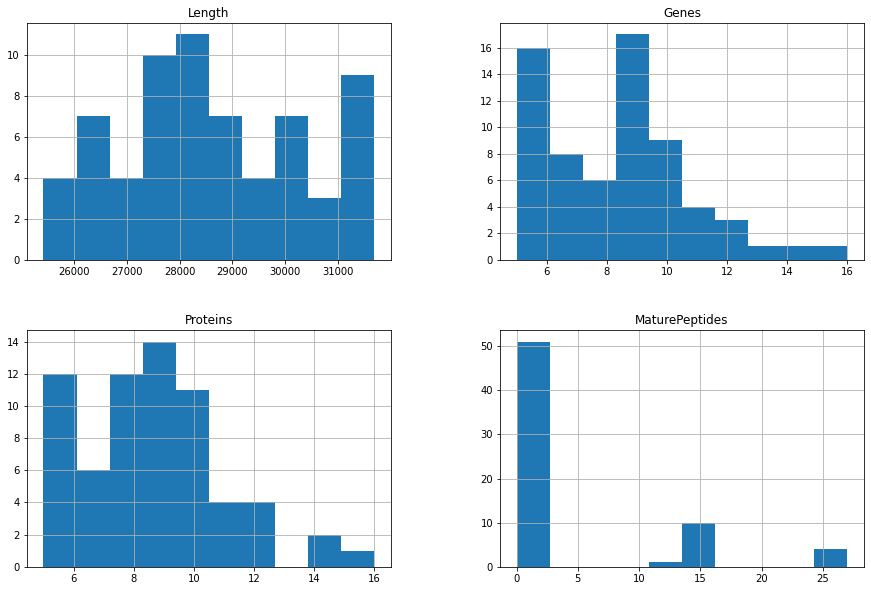

In [1]:
df1.hist(column=['Length', 'Genes', 'Proteins', 'MaturePeptides'], figsize=(15,10))

Along the same lines, data can be extracted from the `data_report.yaml` file and saved as a tab-delimited file to use in external applications like R and Excel. 

In [1]:
genome_table = [['gene_name', 'nuc_acc', 'nuc_ranges', 'prot_name', 'prot_acc', 'prot_len']]
for g in vd.get_report_assemblies():
    annot = g.annotation
    for gene in annot.genes:
        gene_name = gene.name
        for c in gene.cds:
            ranges = []
            for r in c.nucleotide.range:
                ranges.append([r.begin, r.end])
            prot_len = c.protein.range[-1].end
            genome_table.append([gene.name, c.nucleotide.accession_version, ranges, c.name, c.protein.accession_version, prot_len])

            
tsv_file = 'virus_genome_info.tsv'
with open(tsv_file, 'wt') as f:
    tbl = csv.writer(f, delimiter = '\t', lineterminator = os.linesep)
    tbl.writerows(genome_table)

Finally, we can also use the data report to compute useful summaries, like the CDS length of each protein

In [1]:
cds_lengths = []
for g in vd.get_report_assemblies():
    annot = g.annotation
    for gene in annot.genes: 
        for c in gene.cds:
            cds_len = 0
            for r in c.nucleotide.range:
                cds_len += r.end - r.begin + 1
            cds_lengths.append({
                'Accession': g.accession,
                'Gene': gene.name,
                'Protein': c.name,
                'CDS_Length': cds_len
            })

In [1]:
df2 = pd.DataFrame(cds_lengths)
df2.head()

,Accession,Gene,Protein,CDS_Length
0,NC_001451.1,1ab,ORF1ab polyprotein,19890
1,NC_001451.1,1ab,ORF1a polyprotein,11856
2,NC_001451.1,2,spike protein,3489
3,NC_001451.1,3,3a protein,174
4,NC_001451.1,3,3b protein,195


## Add taxid to the FASTA header

In addition to the data report, the bdbag archive contains one or more sequence files that can be processed together. For example, we can add a different set of attributes to the FASTA header in the sequence files. For this, we will first create a map of genomic accessions to taxids and virus names using the data in `data_report.yaml` file. Then, we will use the `pyfaidx` python module to change the headers in `genomic.fna` FASTA file to include taxids.

In [1]:
taxids_by_accession = dict()

for genome in vd.get_report_assemblies():
    taxids_by_accession[genome.accession] = (genome.virus.tax_id, genome.virus.sci_name)

In [1]:
## parse data catalog 
with zipfile.ZipFile(zipfn, 'r') as zip:
    data_catalog = json.loads(zip.read('ncbi_dataset/data/dataset_catalog.json'))

In [1]:
with zipfile.ZipFile(zipfn, 'r') as zip:
    data = zip.read('ncbi_dataset/data/genomic.fna')
    with open('genomic.fna', 'wb') as f:
        f.write(data)

with open('genomic.out.fna', 'w') as f:
    genomic_seqs = Fasta('genomic.fna')
    for g in genomic_seqs:
        (taxid, org_name) = taxids_by_accession[g.name]
        header = '>' + '|'.join([g.name, str(taxid), org_name, '\n'])
        f.write(header)
        f.write(genomic_seqs[g.name][:].seq + '\n')

## Fetch all SARS-CoV-2 genomes submitted in the past 7 days

Narrowing our focus a little, if we are interested in just SARS-CoV-2 genomes they too can be downloaded using `ncbi.datasets` library as shown below. Here, for example, we will restrict the data returned to only those genomes that were submitted in the past 7 days. 

A python datetime object is created with the desired date and provided to the api instance. 

In [1]:
## to fetch all genomes submitted in the past 7 days
t = 7
d = datetime.now(timezone.utc) - timedelta(days=t)
taxid = 2697049

print(f'Download genomes release since: {d}')
cov2_genomes = virus_api.virus_genome_download(
    taxid, 
    released_since = d.isoformat(),
    include_annotation_type=['PDB_FILES'],
    _preload_content=False)

print('Start downloading ...')
zipfn = 'ncbi_genomes.zip'
with open(zipfn, 'wb') as f:
    f.write(cov2_genomes.data)
print('Finished.')

Download genomes release since: 2020-09-01 10:59:14.899425+00:00
Start downloading ...
Finished.


Now, we can use the information in the data report to tabulate information such as the number of genomes by collection date and georaphic location as shown below. 

In [1]:
# Warning: This step can take several minutes to execute, depending on the size of the request.  
#          You may want ot shorten the time window to less than 7 days.
vd = VirusDataset(zipfn)

coll_by_month = Counter()
geo_by_date = []

for g in vd.get_report_assemblies():
    coll_date = g.isolate.collection_date
    coll_date = '/'.join(coll_date.split('-')[:2])
    coll_by_month[coll_date] += 1
    
    geo_by_date.append({
        'Date': g.isolate.collection_date,
        'Location': g.location.geographic_location.split(':')[0]
    })    

print(coll_by_month)

Counter({'2020/07': 3631, '2020/06': 515, '2020/04': 229, '2020/08': 145, '2020': 135, '2020/03': 117, '2020/05': 94, '': 2, '2020/01': 1})


<AxesSubplot:>

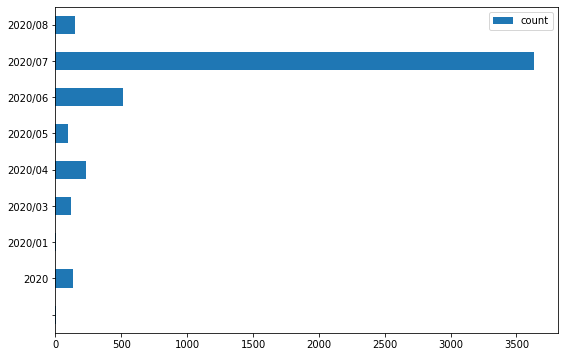

In [1]:
df = pd.DataFrame.from_dict(coll_by_month, orient='index', columns=['count']).sort_index()
df.plot(kind = 'barh', y='count', figsize=(9,6))

In [1]:
df3 = pd.DataFrame(geo_by_date)
df3.head()

,Date,Location
0,2020-06,USA
1,2020-06,USA
2,2020-06,USA
3,2020-06,USA
4,2020-06,USA


<AxesSubplot:>

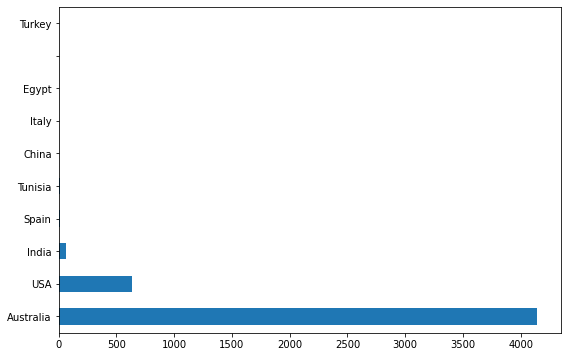

In [1]:
pd.value_counts(df3['Location']).plot.barh(figsize=(9,6))